In [1]:
from qiskit import BasicAer, Aer, IBMQ
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.initial_states import Zero
from qiskit.aqua.components.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA
from qiskit.aqua.components.variational_forms import RY, RYRZ, SwapRZ
from qiskit.aqua.operators import WeightedPauliOperator, Z2Symmetries
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock

from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import QuantumError, ReadoutError
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise.errors import depolarizing_error
from qiskit.providers.aer.noise.errors import thermal_relaxation_error

from qiskit.providers.aer import noise
provider = IBMQ.load_account()

import numpy as np
import matplotlib.pyplot as plt
from functools import partial

# Qiskit Summer School Final Project: VQE

#### For this optional final challenge, you will be designing your own implementation of a variational quantum eigensolver (VQE) algorithm that simulates the ground state energy of the Lithium Hydride (LiH) molecule. Through out this challenge, you will be able to make choices on how you want to compose your simulation and what is the final deliverable that you want to showcase to your classmates and friends.

# Defining your molecule:
In this challenge we will focus on LiH using the sto3g basis with the PySCF driver, which can be described in Qiskit as follows, where 'inter_dist' is the interatomic distance.

In [2]:
inter_dist=1.6
driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis='sto3g')

QiskitChemistryError: 'PySCF is not installed. See https://sunqm.github.io/pyscf/install.html'

We also setup the molecular orbitals to be considered and can reduce the problem size when we map to the qubit Hamiltonian so the amount of time required for the simulations are reasonable for a laptop computer.

In [3]:
# please be aware that the idx here with respective to original idx
freeze_list = [0]
remove_list = [-3, -2] # negative number denotes the reverse order

#### Once you have computed the qubit operations for LiH, you can use the following function to classical solve for the exact solution. This is used just to compare how well your VQE approximation is performing.

In [4]:
#Classically solve for the lowest eigenvalue
def exact_solver(qubitOp):
    ee = ExactEigensolver(qubitOp)
    result = ee.run()
    ref = result['energy']
    print('Reference value: {}'.format(ref))
    return ref

Here we ask you to use the `statevector_simulator` as the simulation backend for your VQE algorithm.

In [54]:
backend = BasicAer.get_backend('statevector_simulator')
#backend = Aer.get_backend('qasm_simulator')

### Now you can start choosing the components that make up your VQE algorithm!

#### 1. Optimizers
The most commonly used optimizers are `COBYLA`, `L_BFGS_B`, `SLSQP` and `SPSA`. 

#### 2. Qubit mapping
There are several different mappings for your qubit Hamiltonian, `parity`, `bravyi_kitaev`, `jordan_wigner`, which in some cases can allow you to further reduce the problem size.

#### 3. Initial state
There are different initial state that you can choose to start your simulation. Typically people choose from the zero state 
`init_state = Zero(qubitOp.num_qubits)` 
and the UCCSD initial state
`HartreeFock(qubitOp.num_qubits, num_spin_orbitals, num_particles, map_type, qubit_reduction)`

#### 4. Parameterized circuit
There are different choices you can make on the form of variational forms of your parameterized circuit.

`UCCSD_var_form = UCCSD(num_qubits, depth=depth, num_orbitals=num_spin_orbitals, num_particles=num_particles)`
    
`RY_var_form = RY(num_qubits, depth=depth)`
    
`RYRZ_var_form = RYRZ(num_qubits, depth=depth)`
    
`swaprz_var_form = SwapRZ(num_qubits, depth=depth)`

#### 5. Simulation backend
There are different simulation backends that you can use to perform your simulation

`backend = BasicAer.get_backend('statevector_simulator')`

`backend=Aer.get_backend('qasm_simulator')`

### Compare the convergence of different choices for building your VQE algorithm

Among the above choices, which combination do you think would out perform others and give you the lowest estimation of LiH ground state energy with the quickest convergence? Compare the results of different combinations against each other and against the classically computed exact solution at a fixed interatomic distance, for example `inter_dist=1.6`. 

To access the intermediate data during the optimization, you would need to utilize the `callback` option in the VQE function:

`def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)
            params.append(parameters)
            deviation.append(std)`
            
`algo = VQE(qubitOp, var_form, optimizer, callback=store_intermediate_result)`

`algo_result = algo.run(quantum_instance)`

An example of comparing the performance of different optimizers while using the RY variational ansatz could like the following:
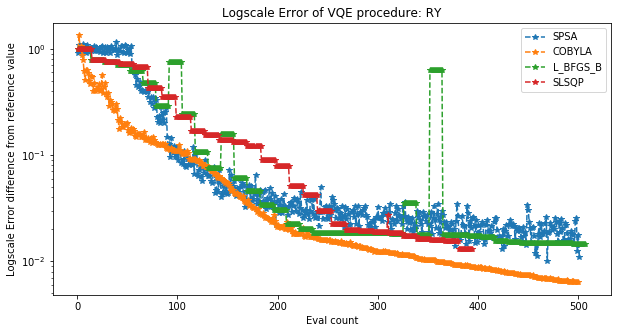
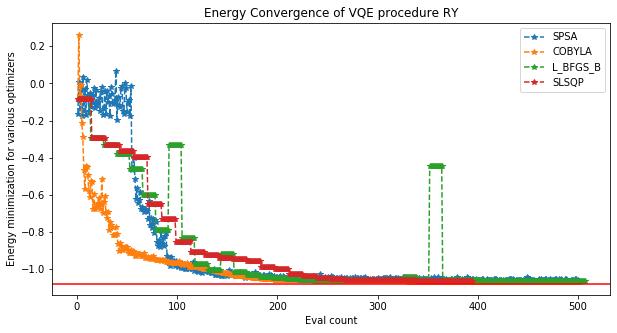

### Compute the ground state energy of LiH at various different interatomic distances
By changing the parameter `inter_dist`, you can use your VQE algorithm to calculate the ground state energy of LiH at various interatomic distances, and potentially produce a plot as you are seeing here. Note that the VQE results are very close to the exact results, and so the exact energy curve is hidden by the VQE curve.
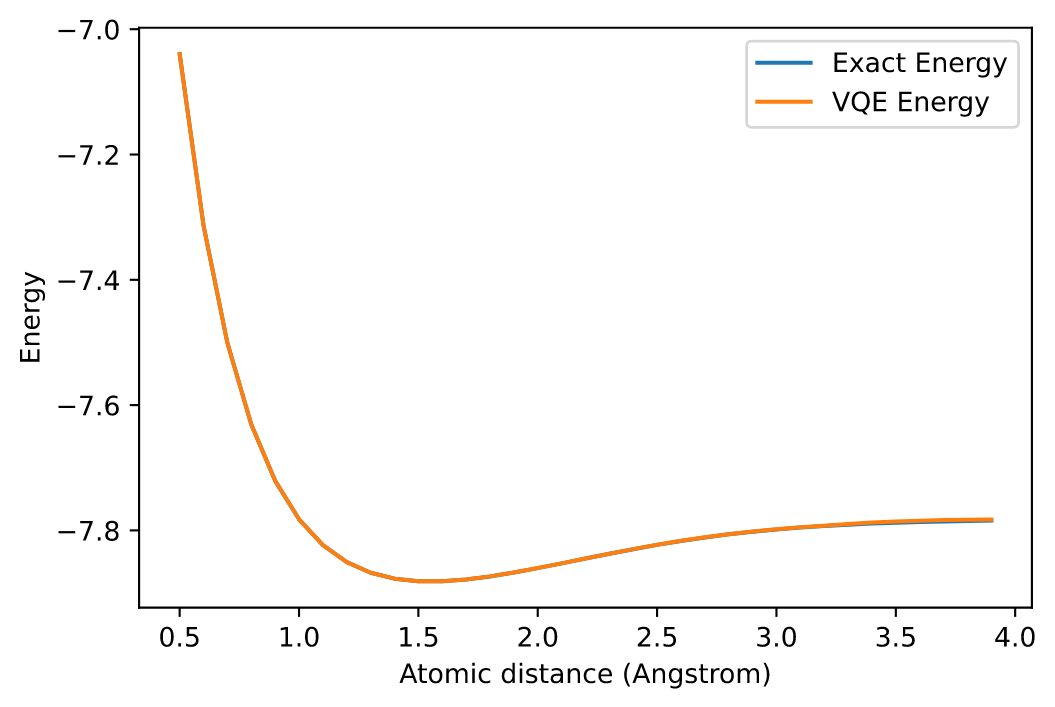

### How does your VQE algorithm perform in the presence of noise?
Trying importing the noise model and qubit coupling map of a real IBM quantum device into your simulation. You can use the imported noise model in your simulation by passing it into your quantum instance. You can also try enabling error mitigation in order to lower the effect of noise on your simulation results.

In [6]:
#Define our noise model based on the ibmq_essex chip
chip_name = 'ibmq_essex'
device = provider.get_backend(chip_name)
coupling_map = device.configuration().coupling_map
noise_model = noise.device.basic_device_noise_model(device.properties())
basis_gates = noise_model.basis_gates

/home/vars/anaconda3/envs/Qiskit/lib/python3.8/site-packages/qiskit/providers/aer/noise/device/basic_device_model.py:111: DeprecationWarning: This function is been deprecated and moved to a method of the`NoiseModel` class. For equivalent functionality use `NoiseModel.from_backend(properties, **kwargs).
  warnings.warn(


An example of comparing the energy convergence of using SPSA and COBYLA with the ibmq_essex noise model could look like the following
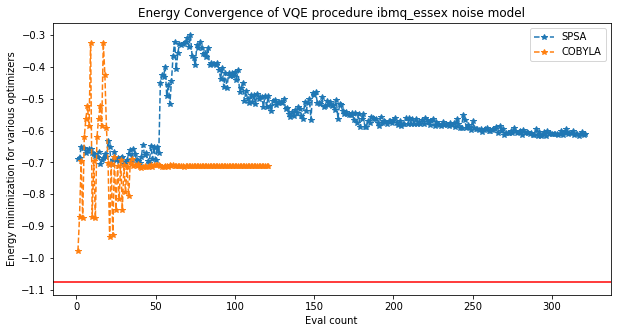

### Now given the choices you have made above, try writing your own VQE algorithm in Qiskit. You can find an example of using Qiskit to simuate molecules with VQE [here](https://qiskit.org/textbook/ch-applications/vqe-molecules.html).

Inter Atomic Distance: 0.5
HF energy: -10.203473360061938
# of electrons: 4
# of spin orbitals: 12
Reference value: [-7.03973252]
VQE result (eigenvalue) -7.0397323921566075

VQE Summary: {'optimal_parameters': {Parameter(θ[0]): 0.02516751170993333, Parameter(θ[1]): 0.009475044734025656, Parameter(θ[2]): 0.025166399454567737, Parameter(θ[3]): 0.009475193471368895, Parameter(θ[4]): -0.059070155446512854, Parameter(θ[5]): 0.04233169025850978, Parameter(θ[6]): 0.042367162901300395, Parameter(θ[7]): -0.07727253107369848}, 'optimal_point': array([ 0.02516751,  0.00947504,  0.0251664 ,  0.00947519, -0.05907016,
        0.04233169,  0.04236716, -0.07727253]), 'optimal_value': -0.97926741650313, 'optimizer_evals': 73, 'optimizer_time': 17.214083194732666, 'eigenvalue': (-0.97926741650313+0j), 'eigenstate': array([-6.72183869e-03+6.66850511e-03j, -6.24500451e-16-1.04083409e-15j,
       -1.78585133e-02+1.77168172e-02j, -7.04805331e-01+6.99213143e-01j,
       -3.01370575e-02+2.98979389e-02j,  0.0

HF energy: -9.251953751729781
# of electrons: 4
# of spin orbitals: 12
Reference value: [-7.82359928]
VQE result (eigenvalue) -7.823599270057231

VQE Summary: {'optimal_parameters': {Parameter(θ[0]): 0.024605780253849255, Parameter(θ[1]): 0.002052692194087383, Parameter(θ[2]): 0.024605692548674972, Parameter(θ[3]): 0.0020538089328783673, Parameter(θ[4]): -0.02656479597958826, Parameter(θ[5]): 0.044820090838512044, Parameter(θ[6]): 0.044858350430235956, Parameter(θ[7]): -0.09715661840132271}, 'optimal_point': array([ 0.02460578,  0.00205269,  0.02460569,  0.00205381, -0.0265648 ,
        0.04482009,  0.04485835, -0.09715662]), 'optimal_value': -1.167749692174, 'optimizer_evals': 64, 'optimizer_time': 15.433417081832886, 'eigenvalue': (-1.167749692174+0j), 'eigenstate': array([-1.45374530e-03+1.44742760e-03j, -3.74700271e-16-1.11022302e-15j,
       -1.74296874e-02+1.73539413e-02j, -7.03217035e-01+7.00160987e-01j,
       -3.17517050e-02+3.16137181e-02j,  0.00000000e+00+0.00000000e+00j,
  

HF energy: -8.790987097121475
# of electrons: 4
# of spin orbitals: 12
Reference value: [-7.87826817]
VQE result (eigenvalue) -7.878268153871622

VQE Summary: {'optimal_parameters': {Parameter(θ[0]): 0.03813832745653836, Parameter(θ[1]): 0.006026782398112528, Parameter(θ[2]): 0.038129207001713114, Parameter(θ[3]): 0.006028368270534209, Parameter(θ[4]): -0.04364304119157583, Parameter(θ[5]): 0.06635262088663987, Parameter(θ[6]): 0.06650171372225928, Parameter(θ[7]): -0.12473324234115321}, 'optimal_point': array([ 0.03813833,  0.00602678,  0.03812921,  0.00602837, -0.04364304,
        0.06635262,  0.06650171, -0.12473324]), 'optimal_value': -1.05474533145578, 'optimizer_evals': 56, 'optimizer_time': 10.620413780212402, 'eigenvalue': (-1.05474533145578+0j), 'eigenstate': array([-4.27599625e-03+4.23446542e-03j, -6.66133815e-16-1.02695630e-15j,
       -2.70723972e-02+2.68094552e-02j, -7.00235409e-01+6.93434336e-01j,
       -4.71640460e-02+4.67059627e-02j,  0.00000000e+00+0.00000000e+00j,
  

HF energy: -8.486035628495896
# of electrons: 4
# of spin orbitals: 12
Reference value: [-7.83725797]
VQE result (eigenvalue) -7.8372579530924344

VQE Summary: {'optimal_parameters': {Parameter(θ[0]): 0.0832918886624943, Parameter(θ[1]): 0.012554812009038926, Parameter(θ[2]): 0.0831672163977581, Parameter(θ[3]): 0.012598635827728091, Parameter(θ[4]): -0.11064578751884561, Parameter(θ[5]): 0.13304906652026507, Parameter(θ[6]): 0.134235025892142, Parameter(θ[7]): -0.1885423541471591}, 'optimal_point': array([ 0.08329189,  0.01255481,  0.08316722,  0.01259864, -0.11064579,
        0.13304907,  0.13423503, -0.18854235]), 'optimal_value': -0.932200216493, 'optimizer_evals': 55, 'optimizer_time': 10.221618890762329, 'eigenvalue': (-0.932200216493+0j), 'eigenstate': array([-8.95602848e-03+8.67230197e-03j, -6.38378239e-16-1.02695630e-15j,
       -5.95559712e-02+5.76692412e-02j, -6.84382075e-01+6.62700886e-01j,
       -9.48417830e-02+9.18372003e-02j,  0.00000000e+00+0.00000000e+00j,
        7.3

HF energy: -8.269643484101085
# of electrons: 4
# of spin orbitals: 12
Reference value: [-7.8019736]
VQE result (eigenvalue) -7.8019733652832155

VQE Summary: {'optimal_parameters': {Parameter(θ[0]): 0.15078501783085754, Parameter(θ[1]): -0.037049426492412496, Parameter(θ[2]): 0.14922554545069605, Parameter(θ[3]): -0.03763562530307775, Parameter(θ[4]): -0.2900545511615452, Parameter(θ[5]): -0.23771560258076813, Parameter(θ[6]): -0.24475643797127924, Parameter(θ[7]): -0.21475332964217067}, 'optimal_point': array([ 0.15078502, -0.03704943,  0.14922555, -0.03763563, -0.29005455,
       -0.2377156 , -0.24475644, -0.21475333]), 'optimal_value': -0.84919233657042, 'optimizer_evals': 63, 'optimizer_time': 13.180522680282593, 'eigenvalue': (-0.84919233657042+0j), 'eigenstate': array([ 3.15052193e-02-1.78043584e-02j,  0.00000000e+00+0.00000000e+00j,
       -1.29231247e-01+7.30316906e-02j, -7.53493748e-01+4.25817467e-01j,
        1.97441149e-01-1.11578750e-01j,  0.00000000e+00+0.00000000e+00j,
 

HF energy: -8.114782068018082
# of electrons: 4
# of spin orbitals: 12
Reference value: [-7.78771697]
VQE result (eigenvalue) -7.787716828109938

VQE Summary: {'optimal_parameters': {Parameter(θ[0]): 0.14942724975233734, Parameter(θ[1]): -0.07106371201403071, Parameter(θ[2]): 0.14570739622832982, Parameter(θ[3]): -0.07311607738688942, Parameter(θ[4]): -0.5175992354076488, Parameter(θ[5]): -0.2686393891952247, Parameter(θ[6]): -0.28020490649670377, Parameter(θ[7]): -0.13934033358178155}, 'optimal_point': array([ 0.14942725, -0.07106371,  0.1457074 , -0.07311608, -0.51759924,
       -0.26863939, -0.28020491, -0.13934033]), 'optimal_value': -0.8035860614623, 'optimizer_evals': 81, 'optimizer_time': 13.962377786636353, 'eigenvalue': (-0.8035860614623+0j), 'eigenstate': array([ 6.07470306e-02-3.33157818e-02j, -1.11022302e-16-1.02695630e-15j,
       -1.28801789e-01+7.06393750e-02j, -6.84846693e-01+3.75593716e-01j,
        2.08132942e-01-1.14147336e-01j,  0.00000000e+00+0.00000000e+00j,
     

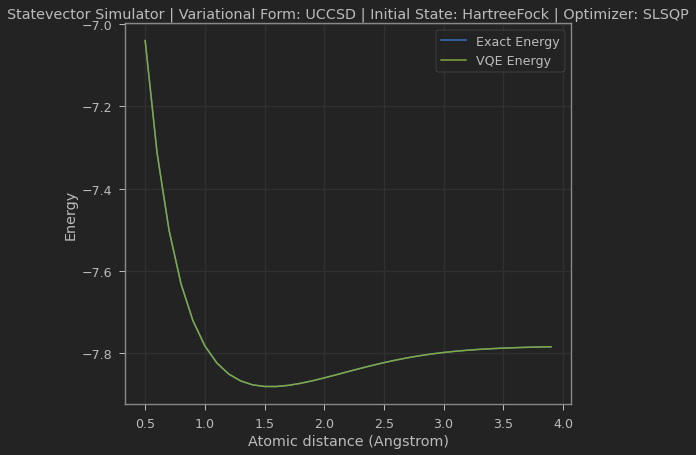

In [66]:
# Classically solve for the lowest eigenvalue
# This is used just to compare how well you VQE approximation is performing
from qiskit.aqua.algorithms import NumPyEigensolver 
#import warnings
#warnings.filterwarnings('ignore')

def exact_solver(qubitOp,shift):
    ee = NumPyEigensolver(qubitOp)
    result = ee.run()
    ref = np.real(result.eigenvalues)+shift
    print('Reference value: {}'.format(ref))
    return ref

# Define your function for computing the qubit operations of LiH
def compute_LiH_qubitOp(map_type, inter_dist, basis='sto3g'):
    
    # Specify details of our molecule
    driver = PySCFDriver(atom='Li .0 .0 .0; H .0 .0 ' + str(inter_dist), unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis)

    # Compute relevant 1 and 2 body integrals.
    molecule = driver.run()
    h1 = molecule.one_body_integrals
    h2 = molecule.two_body_integrals
    nuclear_repulsion_energy = molecule.nuclear_repulsion_energy
    
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
    print("# of electrons: {}".format(num_particles))
    print("# of spin orbitals: {}".format(num_spin_orbitals))

    # Please be aware that the idx here with respective to original idx
    freeze_list = [0]
    remove_list = [-3, -2] # negative number denotes the reverse order
    
    # Prepare full idx of freeze_list and remove_list
    # Convert all negative idx to positive
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    
    # Update the idx in remove_list of the idx after frozen, since the idx of orbitals are changed after freezing
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]

    # Prepare fermionic hamiltonian with orbital freezing and eliminating, and then map to qubit hamiltonian
    # and if PARITY mapping is selected, reduction qubits
    energy_shift = 0.0
    qubit_reduction = True if map_type == 'parity' else False

    ferOp = FermionicOperator(h1=h1, h2=h2)
    if len(freeze_list) > 0:
        ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
        num_spin_orbitals -= len(freeze_list)
        num_particles -= len(freeze_list)
    if len(remove_list) > 0:
        ferOp = ferOp.fermion_mode_elimination(remove_list)
        num_spin_orbitals -= len(remove_list)

    qubitOp = ferOp.mapping(map_type=map_type)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles) if qubit_reduction else qubitOp
    qubitOp=qubitOp
    qubitOp.chop(10**-10)
    shift=energy_shift+nuclear_repulsion_energy

    return qubitOp, num_spin_orbitals, num_particles, qubit_reduction, shift

map_type='parity'
vqe_energy=[]
exact_energy=[]
dist = np.arange(0.5, 4,0.1)

for inter_dist in dist: 
    print("Inter Atomic Distance:", inter_dist)
    qubitOp, num_spin_orbitals, num_particles, qubit_reduction, shift = compute_LiH_qubitOp(map_type,inter_dist)
# Classically solve for the exact solution and use that as your reference value
    ref = exact_solver(qubitOp,shift)
    exact_energy.append(ref)
# Specify your initial state
    init_state = HartreeFock(num_spin_orbitals,num_particles,qubit_mapping='parity')

# Select a state preparation ansatz
# Equivalently, choose a parameterization for our trial wave function.
    var_form = UCCSD(num_orbitals=num_spin_orbitals,num_particles=num_particles,initial_state=init_state,qubit_mapping='parity')

# Choose where to run/simulate our circuit
    quantum_instance = backend

# Choose the classical optimizer
    optimizer = SLSQP(maxiter=10)

# Run your VQE instance
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_run = vqe.run(quantum_instance)
    vqe_result = np.real(vqe_run['eigenvalue'])+shift
    vqe_energy.append(vqe_result)
    print("VQE result (eigenvalue)", vqe_result)
    print()
    print("VQE Summary:",vqe_run)
    print('-----------------------------------------------------------------------------------------------------------------')
# Now compare the results of different compositions of your VQE algorithm!
plt.plot(dist, exact_energy, label="Exact Energy")
plt.plot(dist, vqe_energy, label="VQE Energy")
plt.title('Statevector Simulator | Variational Form: UCCSD | Initial State: HartreeFock | Optimizer: SLSQP')
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.grid()
plt.show()

In [5]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

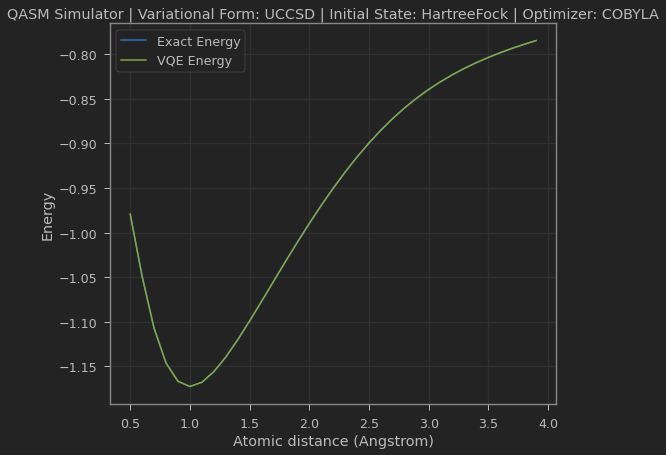

In [50]:
plt.plot(dist, exact_energy, label="Exact Energy")
plt.plot(dist, vqe_energy, label="VQE Energy")
plt.title('QASM Simulator | Variational Form: UCCSD | Initial State: HartreeFock | Optimizer: COBYLA')
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.grid()
plt.show()

In [53]:
print('QASM Simulator | Variational Form: UCCSD | Initial State: HartreeFock | Optimizer: COBYLA')
print()
print("Interatomic Distance:",dist)
print()
print("Exact Energy:",exact_energy)
print()
print("VQE Energy:",vqe_energy)

QASM Simulator | Variational Form: UCCSD | Initial State: HartreeFock | Optimizer: COBYLA

Interatomic Distance: [0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2
 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9]

Exact Energy: [array([-0.97926755]), array([-1.04923604]), array([-1.10724093]), array([-1.14615949]), array([-1.16665291]), array([-1.17245763]), array([-1.1677497]), array([-1.15594837]), array([-1.13951706]), array([-1.12016117]), array([-1.09906409]), array([-1.07705975]), array([-1.05474535]), array([-1.03255463]), array([-1.01080657]), array([-0.98973853]), array([-0.96952926]), array([-0.95031502]), array([-0.93220023]), array([-0.91526353]), array([-0.89955936]), array([-0.88511627]), array([-0.87193365]), array([-0.85997962]), array([-0.84919257]), array([-0.83948685]), array([-0.83076155]), array([-0.82290987]), array([-0.81582691]), array([-0.80941495]), array([-0.80358621]), array([-0.79826377]), array([-0.79338125]), arr

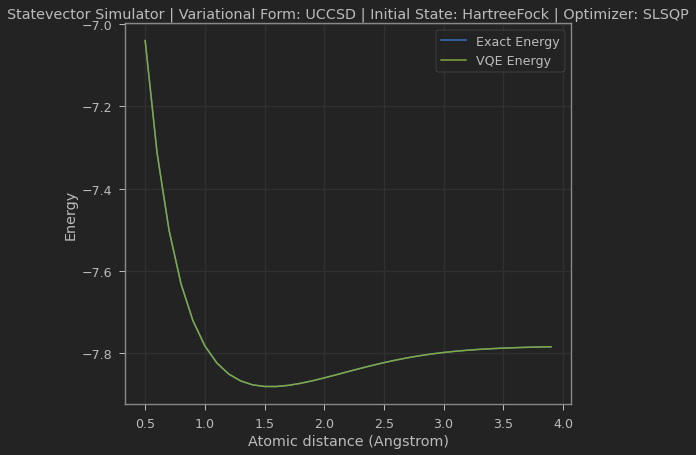

In [64]:
plt.plot(dist, exact_energy2, label="Exact Energy")
plt.plot(dist, vqe_energy2, label="VQE Energy")
plt.title('Statevector Simulator | Variational Form: UCCSD | Initial State: HartreeFock | Optimizer: SLSQP')
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.grid()
plt.show()

In [65]:
print('Statevector Simulator | Variational Form: UCCSD | Initial State: HartreeFock | Optimizer: SLSQP | Added Energy Shift & using jordan_wigner')
print()
print("Interatomic Distance:",dist)
print()
print("Exact Energy:",exact_energy2)
print()
print("VQE Energy:",vqe_energy2)

Statevector Simulator | Variational Form: UCCSD | Initial State: HartreeFock | Optimizer: SLSQP | Added Energy Shift & using jordan_wigner

Interatomic Distance: [0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2
 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9]

Exact Energy: [array([-7.03973252]), array([-7.31334583]), array([-7.50092209]), array([-7.63097825]), array([-7.72081241]), array([-7.7822424]), array([-7.82359928]), array([-7.85069838]), array([-7.86756329]), array([-7.87700149]), array([-7.88101572]), array([-7.88107204]), array([-7.87826817]), array([-7.87344029]), array([-7.86723396]), array([-7.86015321]), array([-7.85259583]), array([-7.84487909]), array([-7.83725797]), array([-7.829937]), array([-7.82307664]), array([-7.81679515]), array([-7.81116828]), array([-7.80622956]), array([-7.8019736]), array([-7.79836343]), array([-7.79534045]), array([-7.79283481]), array([-7.79077401]), array([-7.7890889]), array([-7.78771697]), ar